In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit 
from sklearn.preprocessing import OneHotEncoder

from Bio import pairwise2
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ElasticNet


from sklearn import preprocessing
from Bio.SeqUtils.ProtParam import ProteinAnalysis


from Bio import AlignIO
from Bio import SeqIO
from Bio.Align.Applications import MuscleCommandline
from Bio.Align import AlignInfo
import pandascharm as pc

from Bio.SubsMat.MatrixInfo import blosum62
from Bio.SubsMat.MatrixInfo import blosum45


from sklearn.metrics import r2_score

from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
from sklearn.model_selection import cross_val_score, GroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error

import warnings 
warnings.filterwarnings('ignore') 

import optuna
import xgboost as xgb
from sklearn.model_selection import KFold
import numpy as np

C:\Users\memre\anaconda3\Lib\site-packages\Bio\SubsMat\__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  warnings.warn(


In [2]:
def removeoutlier_col(df,cols):
    Q1 = df[cols].quantile(0.25)
    Q3 = df[cols].quantile(0.75)
    IQR = Q3 - Q1
    df_out = df[~((df[[cols]] < (Q1 - 1.5 * IQR)) |(df[[cols]] > (Q3 + 1.5 * IQR))).any(axis=1)]
    return df_out

In [3]:
def encode(encoding, output, df_clean, aln, esm1b ,key = None):
    
    df_clean = df_clean.set_index('Index')
    
    ClustalAlign = AlignIO.read(aln, 'clustal')
    summary_align = AlignInfo.SummaryInfo(ClustalAlign )
    dframe = pc.from_bioalignment(ClustalAlign).transpose()
    sequences = dframe.loc[df_clean.index]
    
    y = df_clean[output]

    if encoding == 'One_Hot_Encoder':

        one_hot = OneHotEncoder()
        encoded = one_hot.fit(sequences)
        X = encoded.transform(sequences).toarray()

           
    if encoding == 'Bag_of_Words':

        X = pd.DataFrame([ProteinAnalysis(i).count_amino_acids() for i in df_clean['Sequence']])
        X = np.array(X)
        
    if encoding == 'bigram':
        
        X = df_clean['Sequence']
        example = df_clean['Sequence'][0]
        lst = ['E','G','L','Y','T','H','R','A','C','D','P','I','F','N','K','S','V','M','W','Q']
        all_dct = {}
        key = []
        for i in lst:
            for j in lst:
                st = i+j
                all_dct[st] = []

        for example, id in zip(X,range(len(X))):

            temp = list(example)
            temp_dct = dict.fromkeys(all_dct.keys(),0)
            for k in range(len(temp)-1):
                try:
                    check = temp[k] + temp[k+1]
                    temp_dct[check] += 1
                except:
                    pass
            for key, value in temp_dct.items():
                all_dct[key].append(value)
                
                
        X = pd.DataFrame.from_dict(all_dct).set_index(df_clean.index)
        X = np.array(X)
    
    if encoding == 'trigram':
        
        X = df_clean['Sequence']

        example = df_clean['Sequence'][0]
        lst = ['E','G','L','Y','T','H','R','A','C','D','P','I','F','N','K','S','V','M','W','Q']
        all_dct = {}
        key = []
        for i in lst:
            for j in lst:
                for k in lst:
                    st = i+j+k
                    all_dct[st] = []

        for example, id in zip(X,range(len(X))):

            temp = list(example)
            temp_dct = dict.fromkeys(all_dct.keys(),0)
            for k in range(len(temp)-2):
                try:
                    check = temp[k] + temp[k+1]+temp[k+2]
                    temp_dct[check] += 1
                except:
                    pass
            for key, value in temp_dct.items():
                all_dct[key].append(value)
                
        X = pd.DataFrame.from_dict(all_dct).set_index(df_clean.index)
        X = np.array(X)

        
    if encoding == 'quadrogram':
        
        X = df_clean['Sequence']

        example = df_clean['Sequence'][0]
        lst = ['E','G','L','Y','T','H','R','A','C','D','P','I','F','N','K','S','V','M','W','Q']
        all_dct = {}
        key = []
        for i in lst:
            for j in lst:
                for k in lst:
                    for l in lst:
                        st = i+j+k+l
                        all_dct[st] = []

        for example, id in zip(X,range(len(X))):

            temp = list(example)
            temp_dct = dict.fromkeys(all_dct.keys(),0)
            for k in range(len(temp)-3):
                try:
                    check = temp[k] + temp[k+1]+temp[k+2]+temp[k+3]
                    temp_dct[check] += 1
                except:
                    pass
            for key, value in temp_dct.items():
                all_dct[key].append(value)
                
        X = pd.DataFrame.from_dict(all_dct).set_index(df_clean.index)
        X = np.array(X)


    if encoding == 'BLOSUM62':

        n = len(sequences)
        enc_seq = np.zeros((n,n))

        i = 0

        for a in list(sequences.index):
            j = 0
            for b in list(sequences.index):
                enc_seq[i,j] = sum(score_pairwise(sequences.loc[a], sequences.loc[b], blosum62, -5, -1))
                j += 1
            i += 1

        X = np.array(enc_seq)

        
        
        
    if encoding == 'BLOSUM45':
        
        n = len(sequences)
        enc_seq = np.zeros((n,n))

        i = 0

        for a in list(sequences.index):
            j = 0
            for b in list(sequences.index):
                enc_seq[i,j] = sum(score_pairwise(sequences.loc[a], sequences.loc[b], blosum45, -5, -1))
                j += 1
            i += 1
        X = np.array(enc_seq)
      
        
    if encoding == 'ESM1b':

        encoded = esm1b.loc[df_clean.index]
        X = np.array(encoded)

        
    return X
        

In [4]:
def ml_algorithm(algorithm, X_train, y_train, X_val):

    if algorithm == 'Random Forest':

        model = RandomForestRegressor(random_state = 42)
        model.fit(X_train,np.ravel(y_train))
        prediction = model.predict(X_val)


    if algorithm == 'XGBoost':

        model = xgb.XGBRegressor()
        model.fit(X_train, y_train)
        prediction = model.predict(X_val)
            
    if algorithm == 'LASSO':

        model = Lasso()
        model.fit(X_train, y_train)
        prediction = model.predict(X_val)
        
    if algorithm == 'SVR':

        model =  SVR()
        model.fit(X_train, y_train)
        prediction = model.predict(X_val)

    if algorithm == 'Neural Network':
        
        model = MLPRegressor(random_state=101, max_iter=100)
        model.fit(X_train, y_train)
        prediction = model.predict(X_val)
        
    if algorithm == 'Elastic Net':
        
        model = ElasticNet()
        model.fit(X_train, y_train)
        prediction = model.predict(X_val)
        
    return model, prediction

In [5]:
#Model 1: Predicting Optimum Temperature
#Model 2: Predicting Maximum Activity

def model_1_2(X, y, method, algorithm, output, df_clean, aln,esm1b, train_inds, val_inds):
    
    scaler = preprocessing.StandardScaler()
    
    if algorithm in ['LASSO', 'SVR', 'Neural Network']:
        scaler.fit(X)
        X = scaler.transform(X)
    
    
    X_train = X[train_inds]
    y_train = y[train_inds]

    X_val = X[val_inds]
    y_val = y[val_inds]
    
    model, prediction = ml_algorithm(algorithm, X_train, y_train, X_val)
    
    r2=r2_score(y_val, prediction)
    
    
    return model, prediction, r2, scaler

In [6]:
enzyme = 'betaGlucosidasewithMutants'

df = pd.read_excel('betaGlucosidasewithMutantsOptimumTemperature.xlsx')

output = 'pNP-Glc kcat/Km (1/smM)'
aln = enzyme + '.aln'

x = datetime.datetime.now()
date = str(x.year)+str(x.month)+str(x.day)

df['Log'+output] = np.log10(df[output])
esm1b = pd.read_excel(enzyme+'ESM1b_embeddings.xlsx', index_col = 0)

random_state = [202 , 1, 42, 101, 2022,5 , 10, 22, 1995, 0]

In [7]:
models = [['XGBoost', 'ESM1b'],['SVR', 'ESM1b'], ['Random Forest', 'Bag_of_Words']]

In [8]:
import joblib

# Function to save model
def save_model(model, model_name):
    joblib.dump(model, f'{model_name}.joblib')

# Function to load model
def load_model(model_name):
    return joblib.load(f'{model_name}.joblib')

In [10]:
model1_method = 'ESM1b'

model1_algorithm = 'XGBoost'

In [28]:
r2_untuned_list = []
r2_tuned_list = []

for state in random_state:
    
    #Part 1
    df['Relative Temperature'] = df['Reaction Temperature'] - df["Temperature Optimum"]
    
    df_clean = removeoutlier_col(df,'Log' + output).reset_index()
    
    # Create a mapping of unique sequences to unique codes
    sequence_to_code = {seq: f"ENZYME_{i+1}" for i, seq in enumerate(df_clean['Sequence'].unique())}
    
    # Map these codes to a new column in the DataFrame using .loc
    df_clean.loc[:, 'Sequence Code'] = df_clean['Sequence'].map(sequence_to_code)
    
    splitter = GroupShuffleSplit(test_size=.20, n_splits=10, random_state = state)
    
    split = splitter.split(df_clean, groups=df_clean['Sequence Code'])
    
    train_inds, val_inds = next(split)
    
    train_inds_unique = df_clean.iloc[train_inds][df_clean.iloc[train_inds]['Percentage Activity Depending on Optimum Temp']==1].index
    
    val_inds_unique = df_clean.iloc[val_inds][df_clean.iloc[val_inds]['Percentage Activity Depending on Optimum Temp']==1].index

    
    #Part 2
    X_ESM1b  = encode('ESM1b', 'Temperature Optimum', df_clean, aln, esm1b)
    X = X_ESM1b


    #Part 3
    predicted_optimum_temperature_list = []
    model_1_name_list = []
    model_1_r2_list = []
    scaler_dict_model1 = {}
    
    y = df_clean['Temperature Optimum']
    
    
#    model_1, prediction_Topt, r2_1, scaler = model_1_2(X, y, 'ESM1b' , 'XGBoost', 'Temperature Optimum', df_clean, aln, esm1b,
#                              train_inds_unique, val_inds_unique)
    
    model_name_1 = f'{model1_method}_{model1_algorithm}_optimum_temperature_state_{state}'
    model_1 = load_model(model_name_1)


    model_name_1_tuned = f'{model1_method}_{model1_algorithm}_optimum_temperature_state_{state}_tuned'
    model_1_tuned = load_model(model_name_1_tuned)
    
    X_train = X[train_inds_unique]
    y_train = y[train_inds_unique]
    
    X_val = X[val_inds_unique]
    y_val = y[val_inds_unique]


    #Untuned
    prediction_Topt = model_1.predict(X_val)
    r2_untuned = r2_score(y_val,prediction_Topt)
    r2_untuned_list.append(r2_untuned)
    r2_untuned_mean = np.mean(r2_untuned_list)


    #Tuned
    dval = xgb.DMatrix(X_val, label=y_val)
    prediction_Topt_tuned = model_1_tuned.predict(dval)
    r2_tuned = r2_score(y_val,prediction_Topt_tuned)
    r2_tuned_list.append(r2_tuned)
    r2_tuned_mean = np.mean(r2_tuned_list)
    
    print('R2 for the untuned model is ' + str(r2_untuned))
    print('R2 for the tuned model is ' + str(r2_tuned))


print('Average R2 for the untuned model is ' + str(r2_untuned_mean))
print('Average R2 for the tuned model is ' + str(r2_tuned_mean))

        

R2 for the untuned model is 0.855466902256012
R2 for the tuned model is 0.9254277944564819
R2 for the untuned model is 0.8713052272796631
R2 for the tuned model is 0.9128437042236328
R2 for the untuned model is 0.8214419484138489
R2 for the tuned model is 0.8488858938217163
R2 for the untuned model is 0.796097457408905
R2 for the tuned model is 0.8989303708076477
R2 for the untuned model is 0.8004074692726135
R2 for the tuned model is 0.8497429490089417
R2 for the untuned model is 0.7898658514022827
R2 for the tuned model is 0.8354770541191101
R2 for the untuned model is 0.8799461722373962
R2 for the tuned model is 0.8873168230056763
R2 for the untuned model is 0.848997175693512
R2 for the tuned model is 0.8989630341529846
R2 for the untuned model is 0.8059949278831482
R2 for the tuned model is 0.8589468002319336
R2 for the untuned model is 0.8174679279327393
R2 for the tuned model is 0.8185235857963562
Average R2 for the untuned model is 0.8286991059780121
Average R2 for the tuned mod

In [29]:
0.8735058009624481 - 0.8286991059780121

0.04480669498443601

In [34]:
state = 42

In [35]:
#Part 1
df['Relative Temperature'] = df['Reaction Temperature'] - df["Temperature Optimum"]

df_clean = removeoutlier_col(df,'Log' + output).reset_index()

# Create a mapping of unique sequences to unique codes
sequence_to_code = {seq: f"ENZYME_{i+1}" for i, seq in enumerate(df_clean['Sequence'].unique())}

# Map these codes to a new column in the DataFrame using .loc
df_clean.loc[:, 'Sequence Code'] = df_clean['Sequence'].map(sequence_to_code)

splitter = GroupShuffleSplit(test_size=.20, n_splits=10, random_state = state)

split = splitter.split(df_clean, groups=df_clean['Sequence Code'])

train_inds, val_inds = next(split)

train_inds_unique = df_clean.iloc[train_inds][df_clean.iloc[train_inds]['Percentage Activity Depending on Optimum Temp']==1].index

val_inds_unique = df_clean.iloc[val_inds][df_clean.iloc[val_inds]['Percentage Activity Depending on Optimum Temp']==1].index


#Part 2
X_ESM1b  = encode('ESM1b', 'Temperature Optimum', df_clean, aln, esm1b)
X = X_ESM1b


#Part 3
predicted_optimum_temperature_list = []
model_1_name_list = []
model_1_r2_list = []
scaler_dict_model1 = {}

y = df_clean['Temperature Optimum']


In [53]:
final_model = load_model(model_name_1_tuned)

In [54]:
final_model

In [56]:
import json

config = json.loads(final_model.save_config())


In [59]:
def extract_params_from_booster(booster):
    import json
    config = json.loads(booster.save_config())
    booster_type = config["learner"]["gradient_booster"]["name"]
    tree_params = config["learner"]["gradient_booster"]["gbtree_train_param"]
    learner_params = config["learner"]["learner_model_param"]
    train_params = config["learner"].get("training", {}).get("train_param", {})

    # Fix updater field possibly being a list
    updater = config["learner"]["gradient_booster"].get("updater", [])
    if isinstance(updater, list) and len(updater) > 0:
        tree_method = updater[0].get("name", "hist")
    elif isinstance(updater, dict):
        tree_method = updater.get("name", "hist")
    else:
        tree_method = "hist"  # fallback

    params = {
        "verbosity": 0,
        "objective": train_params.get("objective", "reg:squarederror"),
        "eval_metric": train_params.get("eval_metric", "rmse"),
        "booster": booster_type,
        "tree_method": tree_method,
        "lambda": float(tree_params.get("reg_lambda", 1)),
        "alpha": float(tree_params.get("reg_alpha", 0)),
        "gamma": float(tree_params.get("min_split_loss", 0)),
        "max_depth": int(tree_params.get("max_depth", 6)),
        "min_child_weight": float(tree_params.get("min_child_weight", 1)),
        "subsample": float(tree_params.get("subsample", 1.0)),
        "colsample_bytree": float(tree_params.get("colsample_bytree", 1.0)),
        "eta": float(tree_params.get("learning_rate", 0.3)),
        "random_state": int(learner_params.get("seed", 0)),
    }
    return params


In [60]:
params = extract_params_from_booster(final_model)

In [63]:
import pprint
config = json.loads(final_model.save_config())
pprint.pprint(config)


{'learner': {'generic_param': {'device': 'cpu',
                               'fail_on_invalid_gpu_id': '0',
                               'n_jobs': '0',
                               'nthread': '0',
                               'random_state': '42',
                               'seed': '42',
                               'seed_per_iteration': '0',
                               'validate_parameters': '1'},
             'gradient_booster': {'gbtree_model_param': {'num_parallel_tree': '1',
                                                         'num_trees': '72'},
                                  'gbtree_train_param': {'process_type': 'default',
                                                         'tree_method': 'hist',
                                                         'updater': 'grow_quantile_histmaker',
                                                         'updater_seq': 'grow_quantile_histmaker'},
                                  'name': 'gbtree',
          

In [37]:
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

# Create DMatrix for training and validation
dtrain_final = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Define evaluation sets
evals = [(dtrain_final, 'train'), (dval, 'validation')]

# Train model while storing evaluation history
evals_result = {}

final_model = load_model(model_name_1_tuned)

# Predict on validation set
predictions = final_model.predict(dval)

# Print evaluation metrics
print('R2 validation is', r2_score(y_val, predictions))
print('RMSE validation is', root_mean_squared_error(y_val, predictions))



# Plot RMSE over boosting rounds
epochs = len(evals_result['train']['rmse'])
x_axis = range(epochs)

plt.figure(figsize=(8, 5))
plt.plot(x_axis, evals_result['train']['rmse'], label='Train')
plt.plot(x_axis, evals_result['validation']['rmse'], label='Validation')
plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.title('Train vs Validation RMSE')
plt.legend()

plt.tight_layout()
#plt.savefig("20250609 XGB+ESM1b Optimum Temperature Tuned" + str(state) + ".png", dpi=300, bbox_inches='tight')
plt.show()

R2 validation is 0.8185235857963562
RMSE validation is 10.2716703414917


KeyError: 'train'

In [9]:
state = 5

In [10]:
df['Relative Temperature'] = df['Reaction Temperature'] - df["Temperature Optimum"]

df_clean = removeoutlier_col(df,'Log' + output).reset_index()

# Create a mapping of unique sequences to unique codes
sequence_to_code = {seq: f"ENZYME_{i+1}" for i, seq in enumerate(df_clean['Sequence'].unique())}

# Map these codes to a new column in the DataFrame using .loc
df_clean.loc[:, 'Sequence Code'] = df_clean['Sequence'].map(sequence_to_code)

splitter = GroupShuffleSplit(test_size=.20, n_splits=10, random_state = state)

split = splitter.split(df_clean, groups=df_clean['Sequence Code'])

train_inds, val_inds = next(split)

train_inds_unique = df_clean.iloc[train_inds][df_clean.iloc[train_inds]['Percentage Activity Depending on Optimum Temp']==1].index

val_inds_unique = df_clean.iloc[val_inds][df_clean.iloc[val_inds]['Percentage Activity Depending on Optimum Temp']==1].index

In [11]:
X_ESM1b  = encode('ESM1b', 'Temperature Optimum', df_clean, aln, esm1b)

In [12]:
X = X_ESM1b

In [13]:
predicted_optimum_temperature_list = []
model_1_name_list = []
model_1_r2_list = []
scaler_dict_model1 = {}

y = df_clean['Temperature Optimum']


model_1, prediction_Topt, r2_1, scaler = model_1_2(X, y, 'ESM1b' , 'XGBoost', 'Temperature Optimum', df_clean, aln, esm1b,
                          train_inds_unique, val_inds_unique)

#model_name_1 = f'{model1_method}_{model1_algorithm}_optimum_temperature_state_{state}'
#save_model(model_1, model_name_1)

predicted_optimum_temperature_list.append(prediction_Topt)


X_train = X[train_inds_unique]
y_train = y[train_inds_unique]

X_val = X[val_inds_unique]
y_val = y[val_inds_unique]

print('R2 for the untuned model is ' + str(r2_score(y_val,prediction_Topt)))
print('RMSE for the untuned model is ' + str(root_mean_squared_error(y_val, prediction_Topt)))

R2 for the untuned model is 0.7898658514022827
RMSE for the untuned model is 12.956289291381836


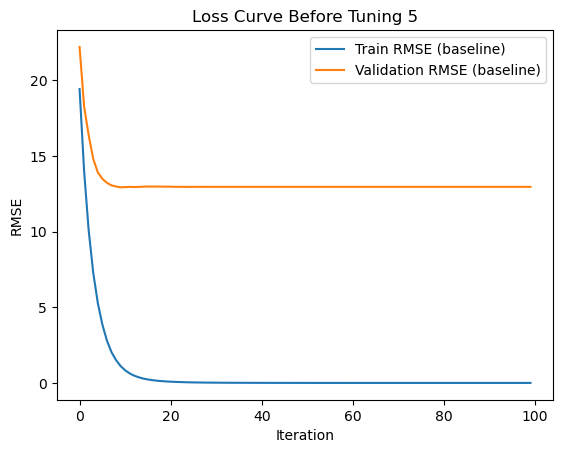

In [14]:
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

 # Prepare DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Baseline parameters
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse"
}

evals_result_baseline = {}

# Train baseline model
xgb.train(
    params,
    dtrain,
    num_boost_round=100,
    evals=[(dtrain, "train"), (dval, "validation")],
    evals_result=evals_result_baseline,
    verbose_eval=False
)

# Plot
plt.plot(evals_result_baseline["train"]["rmse"], label="Train RMSE (baseline)")
plt.plot(evals_result_baseline["validation"]["rmse"], label="Validation RMSE (baseline)")
plt.title("Loss Curve Before Tuning "+ str(state))
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.legend()

plt.savefig("20250609 XGB+ESM1b Optimum Temperature Untuned" + str(state) + ".png", dpi=300, bbox_inches='tight')
plt.show()


In [15]:
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
import numpy as np
import xgboost as xgb


def objective(trial):
    param = {
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        "lambda": trial.suggest_float("lambda", 1, 100.0),
        "alpha": trial.suggest_float("alpha", 1, 100.0),
        "gamma": trial.suggest_float("gamma", 0, 20),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 100),
        "subsample": trial.suggest_float("subsample", 0.4, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "eta": trial.suggest_float("eta", 0.01, 0.1, log=True),
        "tree_method": "hist",
        "random_state": 42,
        "eval_metric": "rmse"
    }

    if param["booster"] == "dart":
        param.update({
            "sample_type": trial.suggest_categorical("sample_type", ["uniform", "weighted"]),
            "normalize_type": trial.suggest_categorical("normalize_type", ["tree", "forest"]),
            "rate_drop": trial.suggest_float("rate_drop", 0.05, 0.3),
            "skip_drop": trial.suggest_float("skip_drop", 0.05, 0.3),
        })

    kfold = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)
    fold_scores = []
    rmse_score_list = []

    for train_idx, val_idx in kfold.split(X_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        dtrain = xgb.DMatrix(X_tr, label=y_tr)
        dval = xgb.DMatrix(X_val, label=y_val)

        model = xgb.train(
            params=param,
            dtrain=dtrain,
            num_boost_round=100,
            evals=[(dval, 'validation')],
            early_stopping_rounds=10,
            verbose_eval=False
        )

        y_pred = model.predict(dval)
        y_pred_train = model.predict(dtrain)
        
        rmse_val = root_mean_squared_error(y_val, y_pred)
        rmse_train = root_mean_squared_error(y_tr, y_pred_train)
        
        tol = np.absolute(rmse_train - rmse_val)

        rmse_score_list.append(rmse_val)
        fold_scores.append(tol)

    return np.mean(rmse_score_list), np.mean(fold_scores)


In [16]:
# Run the Optuna study
study = optuna.create_study(directions =["minimize", "minimize"])  # MSE minimization
study.optimize(objective, n_trials=1000)



[I 2025-06-24 20:44:05,429] A new study created in memory with name: no-name-e83901bd-9e1d-40dc-a153-47fe97bb00f5
[I 2025-06-24 20:44:31,247] Trial 0 finished with values: [17.753769397735596, 1.9271767616271973] and parameters: {'booster': 'dart', 'lambda': 59.017450057133395, 'alpha': 11.257103264863783, 'gamma': 18.954295632555667, 'max_depth': 7, 'min_child_weight': 27, 'subsample': 0.4036725760418725, 'colsample_bytree': 0.5180062578223592, 'eta': 0.07497715134712243, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.12391007251967741, 'skip_drop': 0.1076161982390388}.
[I 2025-06-24 20:44:32,282] Trial 1 finished with values: [27.030280113220215, 2.3755849838256835] and parameters: {'booster': 'gbtree', 'lambda': 6.973132601066119, 'alpha': 17.47788502722479, 'gamma': 10.553055444850237, 'max_depth': 6, 'min_child_weight': 58, 'subsample': 0.5549700962569947, 'colsample_bytree': 0.9648955619642987, 'eta': 0.048094939045093967}.
[I 2025-06-24 20:44:36,888] Trial 2

In [17]:
# Sort all trials lexicographically: (val_rmse, rmse_diff)
sorted_trials = sorted(
    study.best_trials,
    key=lambda t: (t.values[0], t.values[1])  # First by val RMSE, then by RMSE diff
)

# Get the best one based on this order
best_trial = sorted_trials[0]

In [18]:
# Best result
print("Best trial:")
#trial = study.best_trial
trial = best_trial
print(f"  RMSE: {best_trial.values[0]:.4f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Construct best_params
best_params = {
    "verbosity": 0,
    "objective": "reg:squarederror",
    "eval_metric": "rmse",  # MSE used in training
    "booster": trial.params["booster"],
    "tree_method": "hist",
    "lambda": trial.params["lambda"],
    "alpha": trial.params["alpha"],
    "gamma": trial.params["gamma"],
    "max_depth": trial.params["max_depth"],
    "min_child_weight": trial.params["min_child_weight"],
    "subsample": trial.params["subsample"],
    "colsample_bytree": trial.params["colsample_bytree"],
    "eta": trial.params["eta"],
    "random_state": 42,
}

# Add dart-specific parameters if needed
if trial.params["booster"] == "dart":
    best_params.update({
        "sample_type": trial.params["sample_type"],
        "normalize_type": trial.params["normalize_type"],
        "rate_drop": trial.params["rate_drop"],
        "skip_drop": trial.params["skip_drop"]
    })

Best trial:
  RMSE: 7.8407
  Params: 
    booster: gbtree
    lambda: 5.033033165415211
    alpha: 7.148872179841824
    gamma: 10.72513596003391
    max_depth: 6
    min_child_weight: 16
    subsample: 0.914924519637494
    colsample_bytree: 0.6616694117134527
    eta: 0.07135398684029831


R2 validation is 0.8354770541191101
RMSE validation is 11.46424674987793
RMSE training is  2.415966195895352


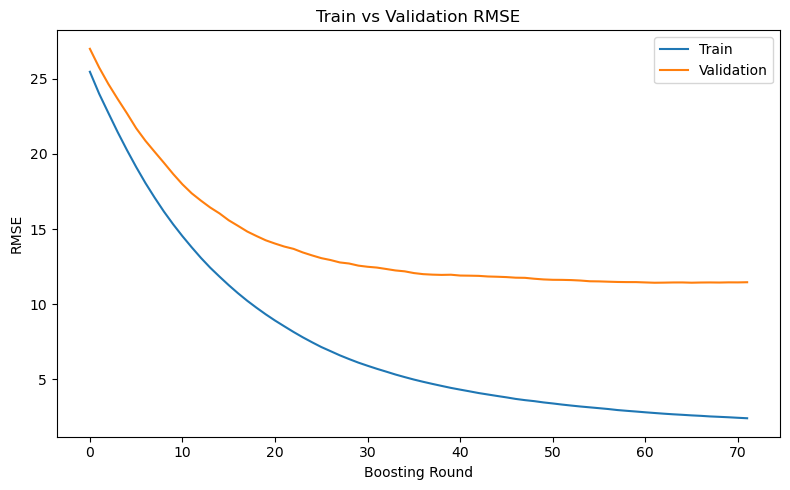

In [19]:
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

# Create DMatrix for training and validation
dtrain_final = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Define evaluation sets
evals = [(dtrain_final, 'train'), (dval, 'validation')]

# Train model while storing evaluation history
evals_result = {}

final_model = xgb.train(
    params=best_params,
    dtrain=dtrain_final,
    num_boost_round=1000,
    evals=evals,
    evals_result=evals_result,
   early_stopping_rounds=10,
    verbose_eval=False
)

# Predict on validation set
predictions = final_model.predict(dval)

# Print evaluation metrics
print('R2 validation is', r2_score(y_val, predictions))
print('RMSE validation is', root_mean_squared_error(y_val, predictions))

print('RMSE training is ', str(evals_result['train']['rmse'][-1]))

# Plot RMSE over boosting rounds
epochs = len(evals_result['train']['rmse'])
x_axis = range(epochs)

plt.figure(figsize=(8, 5))
plt.plot(x_axis, evals_result['train']['rmse'], label='Train')
plt.plot(x_axis, evals_result['validation']['rmse'], label='Validation')
plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.title('Train vs Validation RMSE')
plt.legend()

plt.tight_layout()
plt.savefig("20250609 XGB+ESM1b Optimum Temperature Tuned" + str(state) + ".png", dpi=300, bbox_inches='tight')
plt.show()

In [20]:
save_model(final_model,  'ESM1b_XGBoost_optimum_temperature_state_'+str(state)+'_tuned')

In [21]:
state

5